In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocess Data

In [120]:
from data_utils import PreprocessedDataset
from torchvision.datasets import FashionMNIST
from herlev import HerlevDataset
from torchvision import transforms

labeled = .2
num_labels = 100 # Use this or the variable above, not both
n_neighbors = 5
train_max_size = 2000
test_max_size = 500
size = 256
seed = 2

# Make FashionMNIST
fashion_train = FashionMNIST('sample_data', train=True, transform=None, target_transform=None, download=True)
fashion_test = FashionMNIST('sample_data', train=False, transform=None, target_transform=None, download=True)
fashion_total = PreprocessedDataset(fashion_train, convert_data_attributes=True, max_size=train_max_size, split=labeled, seed=seed)
# Appends the test points for sake of creating the graph, because we are using transductive learning. The test
# labels are discarded
fashion_total.append_test(fashion_test, convert_data_attributes=True, max_size=test_max_size)

# Make Herlev Dataset
# standard_transform = transforms.Compose([
#                 transforms.Resize((size, size)), 
#                 transforms.ToTensor()])
# herlev_train = HerlevDataset('sample_data', train=True, transform=standard_transform, target_transform=standard_transform, download=True)
# herlev_test = HerlevDataset('sample_data', train=False, transform=standard_transform, target_transform=standard_transform, download=True)
# herlev_total = PreprocessedDataset(herlev_train, image_files_to_data_tensor=True, max_size=train_max_size, num_labels=num_labels, center_and_normalize=True)
# Appends the test points for sake of creating the graph, because we are using transductive learning. The test
# labels are discarded
# herlev_total.append_test(herlev_test, image_files_to_data_tensor=True, max_size=test_max_size, center_and_normalize=True)


## Make Graphs

In [103]:
from make_graphs import make_graphs
import sys

make_graphs(fashion_total, 'fashion', ['umap', 'knn'], n_neighbors, save=True)

({'umap': <2500x2500 sparse matrix of type '<class 'numpy.float64'>'
  	with 14870 stored elements in Compressed Sparse Row format>,
  'knn': <2500x2500 sparse matrix of type '<class 'numpy.float64'>'
  	with 12500 stored elements in Compressed Sparse Row format>,
  'tpwrls': None},
 {'umap': 0.4069046974182129, 'knn': 6.072126150131226, 'tpwrls': None})

### Compare Graphs
Compares the adjacency matrices created by different graph construction methods

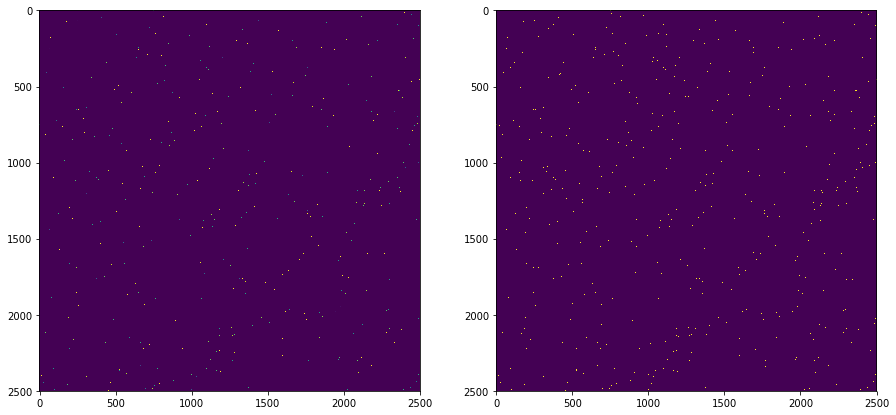

In [104]:
from matplotlib import pyplot as plt
import numpy as np
graph_1 = np.load('graphs/fashion_umap.npy')#[:100, :100]#.astype(np.float64)
graph_2 = np.load('graphs/fashion_knn_kneighbors.npy')#[:100, :100]#.astype(np.float64)
graph_2 = np.maximum(graph_2, graph_2.T)
fig = plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.imshow(graph_1)
plt.subplot(122)
plt.imshow(graph_2)
plt.show()

## Classify/Report Results
Currently not working

[2 9 3 3 9 3 4 3 5 9] tensor([2, 4, 5, 3, 9, 3, 9, 5, 5, 9])


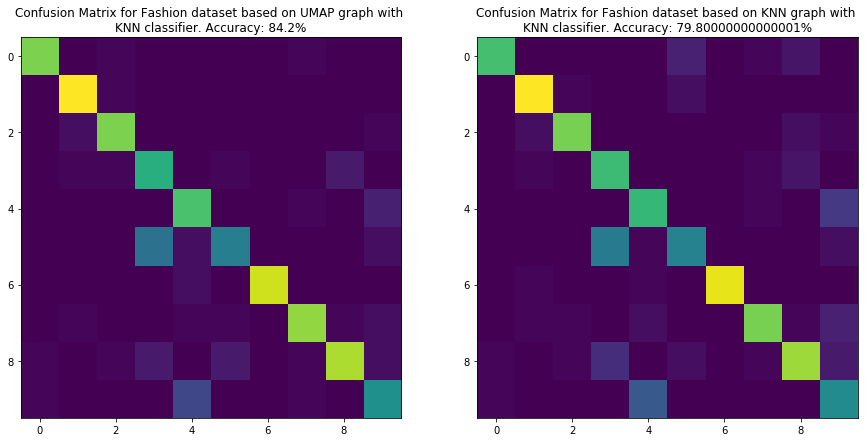

In [121]:
from classifiers import SpectralClassifier
from report_results import plot_acc

fig = plt.figure(figsize=(15,8))

fashion_test_size = test_max_size
classifier = SpectralClassifier(fashion_total.data)

fashion_umap = np.load('graphs/fashion_umap.npy')
classifier.fit(fashion_umap, fashion_total.labels, num_labels)
y_hat = classifier.predict(fashion_total.test_data)
y_truth = fashion_total.test_labels
print(y_hat[:10], y_truth[:10])
plt.subplot(121)
plot_acc(y_truth, y_hat, 'Fashion', 'UMAP', 'KNN')

fashion_knn = np.load('graphs/fashion_knn_kneighbors.npy')
classifier.fit(fashion_knn, fashion_total.labels, num_labels)
y_hat = classifier.predict(fashion_total.test_data)
y_truth = fashion_total.test_labels
plt.subplot(122)
plot_acc(y_truth, y_hat, 'Fashion', 'KNN', 'KNN')